### Setup

In [1]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy.sql import extract
from sqlalchemy import create_engine, text, inspect, func

# data
import pandas as pd
import numpy as np
import datetime as dt

# viz
import seaborn as sns
import matplotlib.pyplot as plt

# Create a base using 'automap_base()' for reflection
Base = automap_base()

In [2]:
SQL_USERNAME = 'postgres'
SQL_PASSWORD = 'postgres'
SQL_IP = 'localhost'
PORT = 5432
DATABASE = 'project_2_group_19'

In [3]:
connection_string = f"postgresql+psycopg2://{SQL_USERNAME}:{SQL_PASSWORD}@{SQL_IP}:{PORT}/{DATABASE}"
engine = create_engine(connection_string)

In [4]:
# Automap base and then use the orm
Base.prepare(autoload_with=engine)

In [5]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['contacts', 'campaign', 'category', 'subcategory']

In [6]:
# Save references to the classes
Contacts = Base.classes.contacts
Category = Base.classes.category
Subcategory = Base.classes.subcategory
Campaign = Base.classes.campaign

In [7]:
# Create a session
session = Session(engine)

### Analysis #1: Get the outcomes by month that projects were started

In [8]:
# Extract the launch date from the Campaign column
launchdate = session.query(Campaign.launched_date).all()

In [9]:
# Get the months each campaign started in
months = []

for date in launchdate:
    launch_date = date[0]
    month = pd.to_datetime(launch_date).month

    months.append(month)

In [10]:
# Get the outcome and country columns
data = session.query(Campaign.outcome, Campaign.country).all()

outcome_df = pd.DataFrame(data)
outcome_df.head()

,outcome,country
0,failed,CA
1,successful,US
2,successful,US
3,failed,US
4,successful,US


In [11]:
# Add the month list to the outcome_df
outcome_df["month"] = months
outcome_df.head()

,outcome,country,month
0,failed,CA,2
1,successful,US,6
2,successful,US,11
3,failed,US,5
4,successful,US,1


In [12]:
# Filter based on outcome
filter1 = outcome_df.outcome == 'canceled'
canceled = outcome_df.loc[filter1].groupby(outcome_df.month).count()

filter2 =  outcome_df.outcome == 'failed'
failed = outcome_df.loc[filter2].groupby(outcome_df.month).count()

filter3 = outcome_df.outcome == 'successful'
successful = outcome_df.loc[filter3].groupby(outcome_df.month).count()

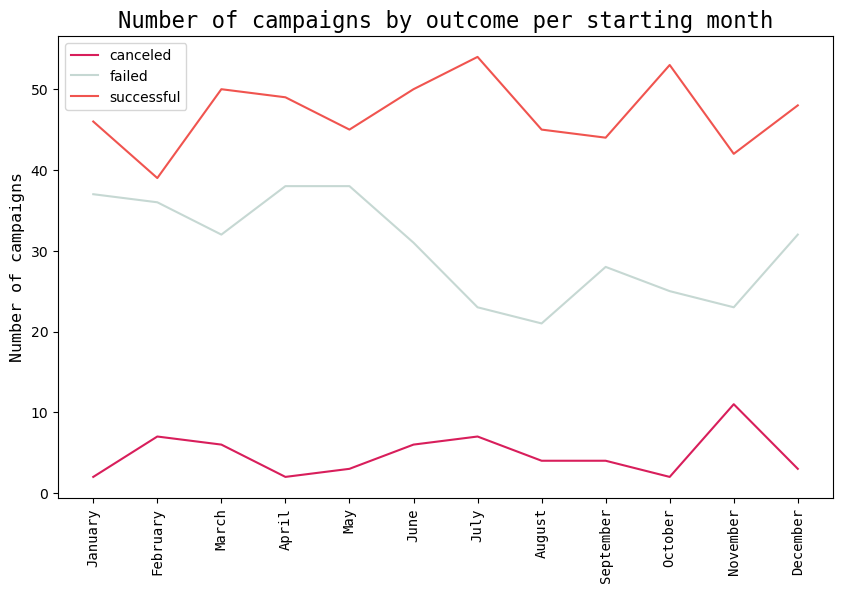

In [23]:
# List of months to names
month_names = ['January',
              'February',
              'March',
              'April',
              'May',
              'June',
              'July',
              'August',
              'September',
              'October',
              'November',
              'December']

# Make a line charts
plt.figure(figsize=(10,6))
ax = plt.axes()

# Make the plots
plt.plot(canceled.month, label='canceled', color='#D81E5B')
plt.plot(failed.month, label='failed', color='#C6D8D3')
plt.plot(successful.month, label='successful', color='#F0544F')

# Add stuff to the plots
# For help with x-tick labels: https://www.geeksforgeeks.org/matplotlib-setting-ticks-and-tick-labels/
ax.set_xticks(np.arange(1, 13))
ax.set_xticklabels(month_names)
plt.xticks(rotation=90, fontfamily='monospace')
plt.ylabel('Number of campaigns', fontfamily='monospace', fontsize=12)
plt.title('Number of campaigns by outcome per starting month', fontfamily='monospace', fontsize=16)

# Add a legend to chart
plt.legend()

# Save figure
plt.savefig("campaign_outcomes_by_month.png")

plt.show()

### Analysis #2: Get the outcomes per each category type

In [14]:
# Do a join on the campaign and category tables
query_results = session.query(Campaign.outcome, Category.category).filter(Campaign.category_id == Category.category_id).all()
cat_outcome_df = pd.DataFrame(query_results)
cat_outcome_df

,outcome,category
0,failed,food
1,successful,food
2,successful,food
3,failed,food
4,successful,food
...,...,...
995,canceled,photography
996,successful,journalism
997,successful,journalism
998,successful,journalism


In [15]:
# Filter based on outcome
filter1 = cat_outcome_df.outcome == 'canceled'
canceled1 = cat_outcome_df.loc[filter1].groupby(cat_outcome_df.category).count()

filter2 =  cat_outcome_df.outcome == 'failed'
failed1 = cat_outcome_df.loc[filter2].groupby(cat_outcome_df.category).count()

filter3 = cat_outcome_df.outcome == 'successful'
successful1 = cat_outcome_df.loc[filter3].groupby(cat_outcome_df.category).count()

filter4 = cat_outcome_df.outcome == 'live'
live1 = cat_outcome_df.loc[filter4].groupby(cat_outcome_df.category).count()

In [16]:
# Adding the missing categories to the canceled DataFrame
# To add new row to the DataFrame with help from: https://stackoverflow.com/a/24287210/23471668
canceled2 = pd.DataFrame([0], columns=['outcome'], index=['journalism'])
canceled3 = pd.concat([canceled1, canceled2]).drop(columns='category')

# Reindexing from: https://stackoverflow.com/a/30010004/23471668
can = canceled3.reindex(['film & video', 'food', 'games', 'journalism', 'music', 'photography',
       'publishing', 'technology', 'theater'])

In [17]:
# Adding the missing categories to the failed DataFrame
# To add new row to the DataFrame with help from: https://stackoverflow.com/a/24287210/23471668
failed2 = pd.DataFrame([0], columns=['outcome'], index=['journalism'])
failed3 = pd.concat([failed1, failed2]).drop(columns='category')

# Reindexing from: https://stackoverflow.com/a/30010004/23471668
fail = failed3.reindex(['film & video', 'food', 'games', 'journalism', 'music', 'photography',
       'publishing', 'technology', 'theater'])

In [18]:
# Adding the missing categories to the live DataFrame
# To add new row to the DataFrame with help from: https://stackoverflow.com/a/24287210/23471668
live2 = pd.DataFrame([0,0,0], columns=['outcome'], index=['food','journalism', 'music'])
live3 = pd.concat([live1, live2]).drop(columns='category')

# Reindexing from: https://stackoverflow.com/a/30010004/23471668
live4 = live3.reindex(['film & video', 'food', 'games', 'journalism', 'music', 'photography',
       'publishing', 'technology', 'theater'])

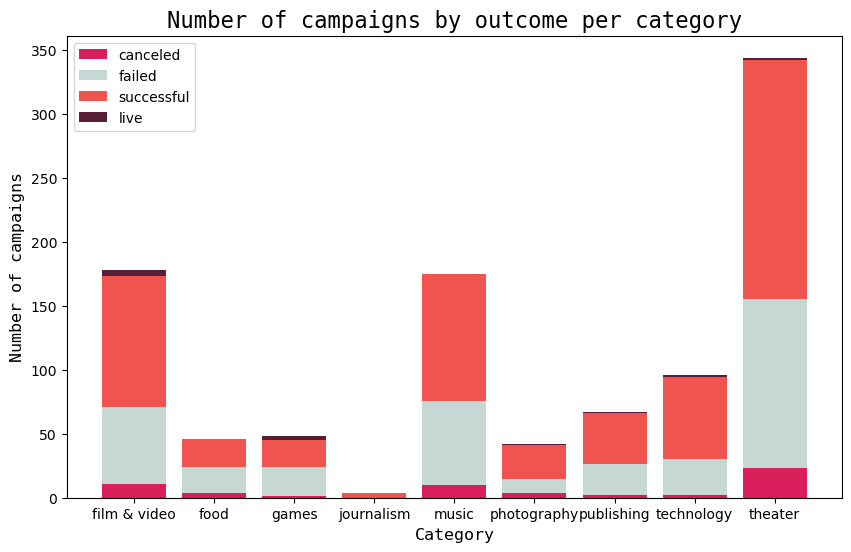

In [19]:
# Make a stacked bar
plt.figure(figsize=(10,6))

x = ['film & video', 'food','games','journalism','music','photography','publishing','technology','theater']
y1 = can.outcome
y2 = fail.outcome
y3 = successful1.outcome
y4 = live4.outcome

# Make the plots
plt.bar(x, y1, label='canceled', color='#D81E5B')
plt.bar(x, y2, bottom=y1, label='failed', color='#C6D8D3')
plt.bar(x, y3, bottom=y1+y2, label='successful', color='#F0544F')
plt.bar(x, y4, bottom=y1+y2+y3, label='live', color='#561F37')

# Add stuff to the plots
plt.xlabel('Category', fontfamily='monospace', fontsize=12)
plt.ylabel('Number of campaigns', fontfamily='monospace', fontsize=12)
plt.title('Number of campaigns by outcome per category', fontfamily='monospace', fontsize=16)

plt.legend()
plt.show()

In [20]:
# End session/engine
engine.dispose()
session.close()